# Tone cluster audio waveform

Francis Deck, October 1, 2016 - 2020

The MIT License (MIT)
Copyright (c) 2016 - 2020 Francis Deck

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Background: How PC based audio analysis works

Here's a block diagram of a general purpose audio analysis setup:

<p align="center">Signal generator $\rightarrow$ Device under test $\rightarrow$ Measurement $\rightarrow$ Analysis</p>

We apply signals to the input of the device being tested, measure its output, and analyze the measurements. For instance, a *frequency response* measurement might apply sinusoidal signals of different frequencies to the device, and measure the output with a voltmeter. Before the personal computer, a lot of measurements were done in this way:

* Set the signal generator to a given frequency
* Write down the frequency and output voltage
* Repeat with another frequency
* And so forth

This process gets tedious, and is fraught with error. Why not let a computer do the work? In fact, early analyzers applied some kind of computer control to the signal generator and voltmeter, and ran through the measurement steps automatically.

That's less tedious, but requires specialized equipment such as a computer controlled signal generator and voltmeter.

Why not let the computer do everything? Today, every personal computer has built-in digital audio hardware, that could be co-opted to perform the functions of both signal generation and measurement. The computer can create any signal that you want -- it's just a sequence of numbers that are fed to the audio output, and the numbers can be computed -- it's just math. The numbers can be computed in real time, but that might be hard because it has to be done quickly. Also, it requires having a way to run the computation on your computer.

Instead, the numbers can be computed once, stored in an audio file such as .WAV or even .MP3 format, and played by the built-in audio player of the PC. And it's easier to just download and use a .WAV file than the program needed to generate it.

On the analysis end, the audio input of the PC turns its input signal back into a stream of numbers. These can be analyzed in real time, and displayed, or stored in a file for later analysis. Now here's a block diagram of the signal generator:

<p style="text-align:center">Audio file containing test signal $\rightarrow$ Playback software $\rightarrow$ PC audio output</p>

And here's a block diagram of the analyzer:

<p style="text-align:center">PC audio input $\rightarrow$ Audio data $\rightarrow$ Analysis software $\rightarrow$ Display</p>

## Theory background: Why we care about sine waves and frequency response
In a real audio system, everything happens in time, and most "notes" are of short duration. Yet we rarely display signals as a function of time, and we use sine waves of infinite duration as our test signals. Music is all about time, but engineers behave like time doesn't matter. What gives?

The reason is that we're looking for ways that we can compare the measured behavior of a system (e.g., an amplifier, speaker, whatever) with a theory of its behavior that lets us make predictions. Sometimes a theory is based on an artificial model of reality. Then we have to justify why we think the model is any good, and why it's useful. Why do we model signals with sinusoids?

<p style="text-align:center">All models are wrong, but some are useful. -- George Box</p>

Frequency analysis assumes a property called "linearity." In formal terms, a function $F$ is said to be linear if $F(A+B) = F(A) + F(B)$. In such systems, there's a perfect correspondence between the time based model, and the frequency based model. And a lot of systems are either perfectly linear, or *linear enough*, or can be rendered *linear enough* for very small signal amplitudes. Thus the linear model is sometimes referred to as the *small signal model*. It's widespread in the fields of engineering and physics.

Linear models work for the small signal behavior of many audio components such as amplifiers and speakers. They don't work very well for things that show amplitude-dependent behavior (such as a guitar distortion pedal), or that have artificially contrived time domain response (such as a reverb effect). But it's useful enough, often enough, to have an analysis system that's dedicated to measuring frequency response using sinusoidal signals.

## The Fourier revolution

Some history of my present employer, written by an early employee: [Nicolet Computers and the Fourier Revolution](http://www.versci.com/)

Getting back to signal analysis, you can feed a sinewave through a device-under-test, and measure theit a output, and then repeat the measurement a bunch of times at different frequencies to obtain a frequency response graph. That's still time consuming and boring. But the linearity rule $F(A+B) = F(A) + F(B)$ gives a clue as to a better way. You can feed multiple sinusoids at different frequencies through the system at once, so long as you can separate them afterward.

The way to separate freqencies is with a Fourier transform, which turns a function of time into a function of frequency, and vice versa. (It does many other things as well, since it's just a general purpose math function). And in the 1960s, as computers were becoming available, some mathematicians invented the [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform#History), an algorithm for converting a set of data points from one domain to the other, quickly. By "quickly" I mean that a modern PC can convert a useful chunk of audio data into a frequency spectrum in a fraction of a second. It's no exaggeration to say that the concept of linearity, Fourier analysis, and digital measurement techniques have all come together to revolutionize many kinds of measurements and scientific instruments.

## Some intimate details of the FFT

The FFT algorithm performs a transformation on what I call a "block" of data, such as a sequence of consecutive values from the audio analog-to-digital converter (ADC) on the PC. The simplest FFT implementations require the block length to be a power of two, such as 2, 4, 8, 16...

How big should the block be? It needs to be big enough that it's longer than the duration of the lowest frequency of interest. Let's say for now that the sampling rate is 44100 Hz, and we care about frequencies down to 10 Hz. Then the block should be at least 0.1 seconds long, or 4410 samples. So a block length of 4096 isn't quite enough, but 8192 should be plenty. That's $2^{13}$. (Note that you can really use any numbers you want, but I'm choosing some values just to make it easier to follow along). We can also generate higher frequencies, all the way up to the so called Nyquist limit, which is half the sampling rate, or 22050 Hz. Most adults can't hear 22050 Hz anyway, so it's plenty.

The FFT actually measures the amplitude and phase at each frequency, a minor detail, but the phase depends on when you actually measure a block of data. Blocks measured at random times will seem to have random phase. They will also have slightly different amplitudes if the block length isn't exactly divisible by the period of each sinusoid. *That's a problem* because you'll get a different result each time you make a measurement.

*To solve that problem*, you can either make the analysis more sophisticated, or make the problem go away by choosing frequencies that have a whole number of periods within the data block. *My tone cluster waveform produces a set of such frequencies.* These frequencies are equal to:

$f_n = n \dfrac {f_s} N$

$n$ = A whole number, e.g., 1, 2, ...

$f_s$ = Sampling frequency for the audio hardware, e.g., 44100 Hz

$N$ = Block length, e.g., 8192

For instance, if $n = 4$, then $f_4 =$ 21.533 Hz.

How should we choose the n's? We could use every possible whole number, but that's a lot of frequencies. And in typical audio systems, the variations in response curves tend to be rather gradual. They can't be closer together than 1, because they're integers. To make them further apart, we could increase them by roughly a constant ratio from point to point. This would result in roughly equally spaced points on a logarithmic graph.

Let's see what we get from the first few integers. Spin up some code...

## Initializing our notebook
When Jupyter starts up, it loads a bare minimum of libraries. If you're going to use more libraries, you have to import them. Using "np" and "plt" for the standard numerical and plotting libraries is a widespread convention.

After importing libraries, we'll define all of the constants used below. Again, it's a convention to put these at the top of the notebook, all in one place. Note that ceil() is the "ceiling" function. It returns the next integer equal to or *bigger* than its argument.

In [3]:
import numpy as np
import wave
%matplotlib inline
import matplotlib.pyplot as plt

In [54]:
blockLength = 8192 # block length in units of samples for waveform, should be a power of 2
sampleRate_Hz = 44100 # sampling rate in samples/sec

durationFile_s = 300 # Length of audio file in seconds
fMin_Hz = 20 # Minimum frequency we're interested in
fMax_Hz = 20000 # Maximum frequency we're interested in
freqRatio = 1.1 # Approximate ratio from one frequency to the next

waveFilename = 'tonez' + str(sampleRate_Hz) + '.wav'
dataFilename = 'tonez' + str(sampleRate_Hz) + '.dat'

In [55]:
n = int(np.ceil(fMin_Hz*blockLength/sampleRate_Hz)) # Starting frequency in cycles per block
cyclesPerBlock = []
freq_Hz = []
while True:
    f = n*sampleRate_Hz/blockLength
    cyclesPerBlock.append(n)
    freq_Hz.append(f)
    n = int(np.ceil(n*freqRatio))
    if f > 20000:
        break

print('n', 'Frequency (Hz)', sep = '\t')
print('-------------------------')
with open(dataFilename, 'w') as dataFile:
    for n, f in zip(cyclesPerBlock, freq_Hz):
        print(n, "{:6.3f}".format(f), sep = '\t')
        print(n, f, file = dataFile, sep = ', ')

n	Frequency (Hz)
-------------------------
4	21.533
5	26.917
6	32.300
7	37.683
8	43.066
9	48.450
10	53.833
11	59.216
13	69.983
15	80.750
17	91.516
19	102.283
21	113.049
24	129.199
27	145.349
30	161.499
33	177.649
37	199.182
41	220.715
46	247.632
51	274.548
57	306.848
63	339.148
70	376.831
77	414.514
85	457.581
94	506.030
104	559.863
115	619.080
127	683.679
140	753.662
154	829.028
170	915.161
188	1012.061
207	1114.343
228	1227.393
251	1351.208
277	1491.174
305	1641.907
336	1808.789
370	1991.821
408	2196.387
449	2417.102
494	2659.351
544	2928.516
599	3224.597
659	3547.595
725	3902.893
798	4295.874
878	4726.538
966	5200.269
1063	5722.449
1170	6298.462
1287	6928.308
1416	7622.754
1558	8387.183
1714	9226.978
1886	10152.905
2075	11170.349
2283	12290.076
2512	13522.852
2764	14879.443
3041	16370.618
3346	18012.524
3681	19815.930
4050	21802.368


We're ready to compute the sinusoids, but there's one more thing. The function $sin(2 \pi f t)$ is exactly zero  for $t = 0$ at all frequencies, thus the sum of sine functions will also be zero. This produces an audible transient with every period of the data block. My solution to this problem is to apply a random phase to each sinusoid, so that the zeros aren't all on top of one another.

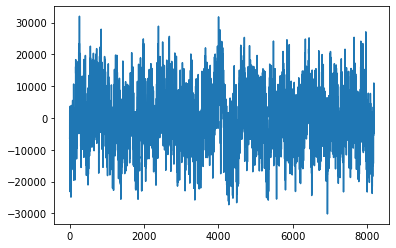

In [56]:
np.random.seed()
tBlock_s = blockLength/sampleRate_Hz
nBlocks = int(np.ceil(durationFile_s/tBlock_s))

t = np.linspace(0, tBlock_s, blockLength, endpoint = False) # Time scale for block, in seconds
block = np.zeros_like(t, dtype = np.float); # Start with a zeroed-out array

for f in freq_Hz:
    block = block + np.sin(2*np.pi*f*t + np.random.rand()*2*np.pi)

# Normalize to +/- 1, with an amplitude just shy of 32768

blockNorm = block*32000/max(abs(block))
plt.plot(blockNorm)
plt.show()

## Plot FFT of first block

...just so we can check our work. The waveform will "look" random. The peaks of the spectrum should be roughly equally spaced, and of uniform height. Also, this is how it will look when measured with a FFT spectrum analyzer, if...

1. The sampling rate and block length for the spectrum analyzer are equal to the values chosen here.
2. No apodization or windowing, if possible. Set "windowing function" to "None."

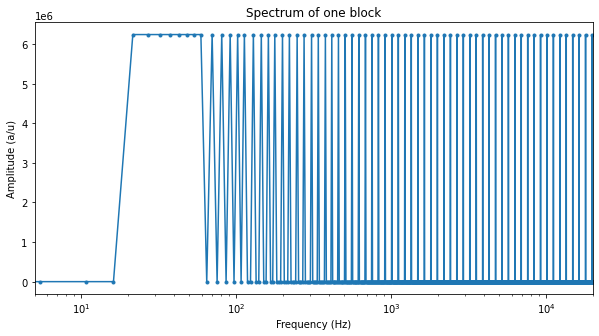

In [57]:
plt.figure(figsize = (10, 5))
b = np.abs(np.fft.rfft(blockNorm))[:-1]
bt = np.linspace(0, sampleRate_Hz/2, blockLength // 2)
plt.semilogx(bt, b, marker = '.')
plt.gca().set_xlim(5, 20000)
plt.title('Spectrum of one block')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (a/u)')
plt.show()

## Write the .WAV file

Convert into integer format, use wave library to create .WAV file

In [58]:
blockInt = np.array(blockNorm, dtype = np.int16)

wf = wave.open(waveFilename, 'wb')
wf.setnchannels(1) # number of channels, this will be monaural
wf.setsampwidth(2) # width of each sample, in bytes
wf.setframerate(sampleRate_Hz) # intended sampling rate
for i in range(nBlocks):
    wf.writeframes(blockInt)
wf.close()